In [ ]:
# Este código foi desenvolvido usando o Google Colaboratory
# e roda utilizando arquivos em um Google Drive

########################################################
##### ANTES DE RODAR DEFINA AS SEGUINTES VARIÁVEIS #####
########################################################

# Dia, mês e ano das medidas:
DD = '06'
MM = '07'
AAAA = '2017'

# Endereço (no drive) do arquivo csv da lookup table gerado no LibRadtran:
# O arquivo deve conter PWV, Cosseno do ângulo zenital, Radiância (separados por vírgulas).
data_table = '/content/drive/My Drive/Doutorado/Dados/Tabelas/lt_2.0_06072017_CH4.csv'

# Valores inicial, final e incremento de PWV usado na lookup table:
Vini = 10.0
Vfin = 22.0
Vinc = 0.1

# Valores inicial, final e incremento do cosseno do angulo zenital usados nas simulações:
Cini = -1.00
Cfin = -0.50
Cinc = 0.025

# Medida do ASIVA 15h17 UTC - Código id do arquivo:
fileid = '19OWUGbVN-M27j2Paw1RTJ6nYjXtVgvST'

# Código de identificação do arquivo de massas de ar no drive:
am_id = '1imaUyPaSLW08b0uQlHFBRE-GKztXVjcF'

# Código de identificação do arquivo de ganhos no drive:
gn_id = '1anDF0bAK4Mk3JJmwCwvUhoVyfvFG_X_-'

In [ ]:
# Imports gerais:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

from scipy.integrate import simps
from scipy.interpolate import interp1d
import scipy.integrate as integrate

from matplotlib.mathtext import DejaVuSerifFontConstants
import time

# Montando o drive para acessar os arquivos csv:
from google.colab import drive

drive.mount('/content/drive')


# Autencicação para acessar arquivos FITS:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from astropy.io import fits

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at /content/drive


In [ ]:
# Método para integração da função de Planck

# Transmitância para CH1 e CH4
lam1 = np.array([7.5,	7.6,	7.7,	7.8,	7.9,	8,	8.1,	8.2,	8.3,	8.4,	8.5,	8.6,	8.7,	8.8,	8.9,	9,	9.1,	9.2,	9.3,	9.4,	9.5,	9.6,	9.7,	9.8,	9.9,	10])
t1 = np.array([0,	0.00099387241,	0.0037543261,	0.016397096,	0.067411996,	0.16470027,	0.23448369,	0.28485084,	0.32886598,	0.36326829,	0.37955591,	0.37672785,	0.37035781,	0.38823766,	0.44920856,	0.49278599,	0.43715978,	0.35334194,	0.26878348,	0.13254657,	0.047449771,	0.014290923,	0.0063342853,	0.0017594688,	0,	0])

lam4 = np.array([9.5, 9.6, 9.7, 9.8, 9.9, 10, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13])
t4 = np.array([0.0000000, 6.1639049e-03, 1.2173898e-02, 2.7315959e-02, 6.6134155e-02, 1.5677769e-01, 3.1759289e-01, 5.0121820e-01, 6.2649029e-01, 6.6445202e-01, 6.7786473e-01, 7.0090240e-01, 7.2765547e-01, 7.4226588e-01, 7.3759609e-01, 7.0764691e-01, 6.6859865e-01, 6.3946754e-01, 6.2751961e-01, 6.2927783e-01, 6.3590199e-01, 6.3487315e-01, 6.2753671e-01, 6.1468023e-01, 5.9755743e-01, 5.8034897e-01, 5.6401944e-01, 5.4896957e-01, 5.3071028e-01, 4.8840195e-01, 3.5360095e-01, 1.7142840e-01, 7.3776573e-02, 3.4712266e-02, 1.7007021e-02, 0.0000000])

# Integral da transmitância.
It1 = simps(t1, lam1)
It4 = simps(t4, lam4)

# Temperatura de 0 a 500 K - Passo de 0.1 K.
T = np.linspace(0, 500, num=5001)

# BB = Integral(f(T)) / It
def f1(T):
    return (t1 * 1.19e+08 * lam1**-5) / (np.exp(1.44e+04 / (lam1 * T)) - 1)

def f4(T):
    return (t4 * 1.19e+08 * lam4**-5) / (np.exp(1.44e+04 / (lam4 * T)) - 1)

BB1 = [simps(f1(x), lam1)/It1 for x in T]
BB4 = [simps(f4(x), lam4)/It4 for x in T]

# Função para fazer a interpolação
BB1_interp = interp1d(T, BB1)
BB4_interp = interp1d(T, BB4)


<ipython-input-3-66dc4ff67ff2>:19: RuntimeWarning: divide by zero encountered in true_divide
  return (t1 * 1.19e+08 * lam1**-5) / (np.exp(1.44e+04 / (lam1 * T)) - 1)
<ipython-input-3-66dc4ff67ff2>:19: RuntimeWarning: overflow encountered in exp
  return (t1 * 1.19e+08 * lam1**-5) / (np.exp(1.44e+04 / (lam1 * T)) - 1)
<ipython-input-3-66dc4ff67ff2>:22: RuntimeWarning: divide by zero encountered in true_divide
  return (t4 * 1.19e+08 * lam4**-5) / (np.exp(1.44e+04 / (lam4 * T)) - 1)
<ipython-input-3-66dc4ff67ff2>:22: RuntimeWarning: overflow encountered in exp
  return (t4 * 1.19e+08 * lam4**-5) / (np.exp(1.44e+04 / (lam4 * T)) - 1)


In [ ]:
# Importando arquivo de airmass e ganhos do Google Drive.

# Arquivo de airmass:
am = 'airmass.fit'
dl = drive.CreateFile({'id': am_id})
dl.GetContentFile(am)
airmass = fits.getdata(am)

# Arquivo de ganho - CH4.
gn4 = 'gn_ch4.fit'
dl = drive.CreateFile({'id': gn_id})
dl.GetContentFile(gn4)
gain4 = fits.getdata(gn4)

In [ ]:
# Calcula o array de massas de ar usado nas simulações do libRadtran:

n = ((Cfin - Cini)/Cinc)+1
sim_cos = np.linspace(Cini, Cfin, round(n))
sim_am = -1/sim_cos

#print('sim_am = '+ str(sim_am) )

sim_am = [1.         1.02564103 1.05263158 1.08108108 1.11111111 1.14285714
 1.17647059 1.21212121 1.25       1.29032258 1.33333333 1.37931034
 1.42857143 1.48148148 1.53846154 1.6        1.66666667 1.73913043
 1.81818182 1.9047619  2.        ]


In [ ]:
# Gerando o array de PWVs usados na lookup table:

num = ((Vfin - Vini)/Vinc)+1

PWV = np.linspace(Vini, Vfin, round(num))

#print('PWV = '+ str(PWV))

PWV = [10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1 11.2 11.3
 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6 12.7
 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1
 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5
 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.6 16.7 16.8 16.9
 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9 18.  18.1 18.2 18.3
 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3 19.4 19.5 19.6 19.7
 19.8 19.9 20.  20.1 20.2 20.3 20.4 20.5 20.6 20.7 20.8 20.9 21.  21.1
 21.2 21.3 21.4 21.5 21.6 21.7 21.8 21.9 22. ]


In [ ]:
# Carregando arquivo lookup table gerada no libRadtran

# Nomes das colunas do arquivo csv
cols=['pwv','cos','airm','rad4']

# Abrindo o arquivo csv com o pandas
ltable = pd.read_csv(data_table, skiprows=1, sep=",", names=cols, na_values=["-9999"])

In [ ]:
#####################
### RADIÂNCIA CH4 ###
#####################

# Carregando arquivo de diferença de contagens:
d4 = 'diff_ch4.fit'
dl = drive.CreateFile({'id': fileid})
dl.GetContentFile(d4)
dif4 = fits.getdata(d4)

# Carregando dados e informações do header:
hdul = fits.open(d4)
hdr = hdul[0].header
  
# Obtendo o Tempo em horas:
eps = hdr['EPOCHS']
t = time.gmtime(eps)

# Temperaturas dos corpos negros interno e externo:
Ti = hdr['INTBBTMP']
Te = hdr['EXTBBTMP']

# Diferença de contagens e ganhos na região do corpo negro externo.
d4reg = dif4[499:504,259:274]
g4reg = gain4[499:504,259:274]

# Medianas calculadas na região do corpo negro externo:
df4 = np.median(d4reg)
g4ext = np.median(g4reg)
  
# Calculo da radiância do corpo negro de referência (interno) na região do corpo negro externo:
Ti_K = Ti + 273.15
Ri4 = BB4_interp(Ti_K)

# Valor de contagens teórico para o corpo negro de referência na região da imagem do corpo negro externo:
c4int = Ri4*g4ext

# Calculo da radiância do corpo negro externo:
Te_K = Te + 273.15
Re4 = BB4_interp(Te_K)

# Valor de contagens teórico para o corpo negro externo:
c4ext = Re4*g4ext

# Offset:
off4 = c4ext - (df4 + c4int)

#######################
### RADIÂNCIA - CH4 ###
#######################
radiance4 = ((dif4 + off4)/gain4) + Ri4

In [ ]:
# Retirada de nuvens e limpeza de dados:
rad_limpa4 = np.copy(radiance4)

# Retirando dados da região externa à imagem:
fora = np.where(airmass < 1)
rad_limpa4[fora] = np.nan

# Mediana da radiância em torno de 3 massas de ar:
mediana_am3 = np.nanmedian(radiance4[np.logical_and(airmass < 3.01, airmass > 2.99)])

# Função que calcula o desvio padrão dos pixels adjacentes ao de coordenada [i,j]:
def desvio_pad (i, j, rad):
  corte = [rad[i-1, j-1], rad[i, j-1], rad[i+1, j-1], rad[i-1, j], rad[i, j], rad[i+1, j], rad[i-1, j+1], rad[i, j+1], rad[i+1, j+1]]
  return np.std(corte)

# Indetifica pixels a remover e transforma em NaN
for i in range (10, 510):
  for j in range (30, 600):
    if ((desvio_pad(i, j, radiance4) > 0.07)|(radiance4[i,j] > mediana_am3)):
      rad_limpa4[i, j] = np.nan

#############################
### RADIÂNCIA LIMPA - CH4 ###
#############################
L_limpa4 = np.copy(rad_limpa4)

In [ ]:
# Limitando em airmass 2:

limite = np.where(airmass > 2)
radiance4[limite] = np.nan
L_limpa4[limite] = np.nan

In [ ]:
# Matriz para guardar PWV de cada pixel:
pwv_img = np.zeros(radiance4.shape)

In [ ]:
# Laços que percorrem todos os pixels da medida:

irange = np.arange(40, 512)
jrange = np.arange(60, 528)

for i in irange:
  for j in jrange:

    if ((airmass[i,j] <=1)|(airmass[i,j] > 2)):
      pwv_img[i,j] = np.nan

    else:
      L_interpolada = []

      for mm in PWV:
        cond = ((ltable.pwv > mm-0.001)&(ltable.pwv < mm+0.001))
        Interpola_am = interp1d(sim_am, ltable.rad4[cond])
        interp_L = Interpola_am(airmass[i,j])
        L_interpolada.append(interp_L)

      Interpola_rad = interp1d(L_interpolada, PWV)
      interp_PWV = Interpola_rad(L_limpa4[i,j])
      pwv_img[i,j] = interp_PWV


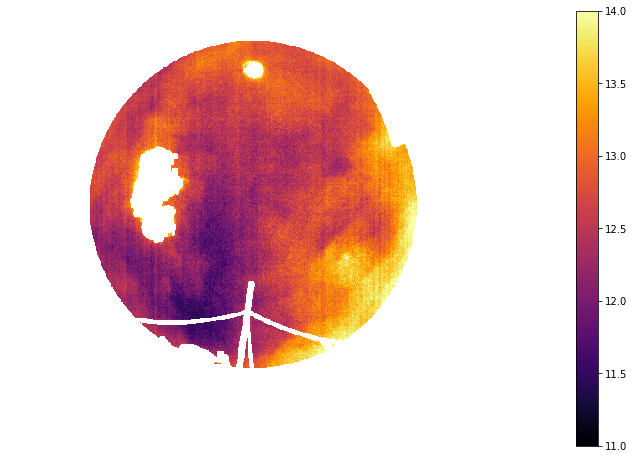

In [ ]:
# Plot da imagem: Radiância espectral em W m⁻²μm⁻¹sr⁻¹

Y = 12
X = 8

fig = plt.figure(1, figsize=(Y,X))
ax = plt.subplot(1, 1, 1)
plt.imshow(pwv_img, cmap='inferno', origin='lower', vmin=11, vmax=14)
plt.axis('off')
plt.colorbar()

In [ ]:
# Gravar resultado em um arquivo fits

hdu = fits.PrimaryHDU(pwv_img)
hdul = fits.HDUList([hdu])
hdul.writeto('pwv_img.fits')